# Discussion of Homework \#2

### Mark Hendricks

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# Some Useful Functions

## This notebook relies on some previously shown functions, kept in `cmds/portfolio.py`

It calls the path to `portfolio.py` then it loads all the functions from `portfolio.py`.

The only function it is using is performanceMetrics(), defined in my notebook for HW#1. 
As I use functions in our class discussions, I will put them in the `cmds/portfolio.py` file.

In [2]:
import sys
sys.path.insert(0, '../cmds')
from portfolio import *

## Function for Displaying Correlation

In [3]:
def display_correlation(df,list_maxmin=True):
    
    corrmat = df.corr()
    #ignore self-correlation
    corrmat[corrmat==1] = None
    sns.heatmap(corrmat)

    if list_maxmin:
        corr_rank = corrmat.unstack().sort_values().dropna()
        pair_max = corr_rank.index[-1]
        pair_min = corr_rank.index[0]

        print(f'MIN Correlation pair is {pair_min}')
        print(f'MAX Correlation pair is {pair_max}')

## Function for univariate tail-risk statistics

In [4]:
def tailMetrics(returns, quantile=.05, relative=False, mdd=True):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis()

    VaR = returns.quantile(quantile)
    CVaR = (returns[returns < returns.quantile(quantile)]).mean()

    if relative:
        VaR /= returns.std()
        CVaR /= returns.std()

    metrics[f'VaR ({quantile})'] = VaR
    metrics[f'CVaR ({quantile})'] = CVaR

    if mdd:
        mdd_stats = maximumDrawdown(returns)
        metrics = metrics.join(mdd_stats)

        if relative:
            metrics['Max Drawdown'] /= returns.std()


    return metrics

## Function for Max Drawdown

In [5]:
def maximumDrawdown(returns):
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max

    max_drawdown = drawdown.min()
    end_date = drawdown.idxmin()
    summary = pd.DataFrame({'Max Drawdown': max_drawdown, 'Bottom': end_date})

    for col in drawdown:
        summary.loc[col,'Peak'] = (rolling_max.loc[:end_date[col],col]).idxmax()
        recovery = (drawdown.loc[end_date[col]:,col])
        try:
            summary.loc[col,'Recover'] = recovery[recovery >= 0].index[0]
        except:
            summary.loc[col,'Recover'] = None

        summary['Peak'] = pd.to_datetime(summary['Peak'])
        summary['Duration (to Recover)'] = (summary['Recover'] - summary['Peak'])
        
        summary = summary[['Max Drawdown','Peak','Bottom','Recover','Duration (to Recover)']]
    return summary    

## Function for OLS Metrics

In [6]:
def get_ols_metrics(regressors, targets, annualization=1, ignorenan=True):
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors, pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets, pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors, how='inner', lsuffix='y ')
    Y = df_aligned[targets.columns]
    Xset = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        
        if ignorenan:
            # ensure we use only non-NaN dates
            alldata = Xset.join(y)
            mask = alldata.notnull().all(axis=1)
            y = y[mask]
            X = Xset[mask]
        else:
            X = Xset

        model = LinearRegression().fit(X, y)
        reg.loc[col, 'alpha'] = model.intercept_ * annualization
        reg.loc[col, regressors.columns] = model.coef_
        reg.loc[col, 'r-squared'] = model.score(X, y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit

        # Treynor Ratio is only defined for univariate regression
        if Xset.shape[1] == 1:
            reg.loc[col,'Treynor Ratio'] = (y.mean() / model.coef_) * annualization

        
        # if intercept =0, numerical roundoff will nonetheless show nonzero Info Ratio
        num_roundoff = 1e-12
        if np.abs(model.intercept_) < num_roundoff:
            reg.loc[col, 'Info Ratio'] = None
        else:
            reg.loc[col, 'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

# Data

In [7]:
filepath_data = '../data/proshares_analysis_data.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.rename(columns={'Unnamed: 0':'Symbol'},inplace=True)
info.set_index('Symbol',inplace=True)

hf = pd.read_excel(filepath_data,sheet_name='hedge_fund_series')
hf.set_index('date',inplace=True)

ml = pd.read_excel(filepath_data,sheet_name='merrill_factors')
ml.set_index('date',inplace=True)

In [8]:
info.loc[list(hf.columns) + list(ml.columns)]

,Descriptions
Symbol,
HFRIFWI Index,Hedge Fund Research HFRI Fund
MLEIFCTR Index,ML Factor Model
MLEIFCTX Index,ML Factor ModelX
HDG US Equity,PROSHARES HEDGE REPLICAT ETF
QAI US Equity,IQ HEDGE MULTI-STRAT TRACKER
SPY US Equity,SPDR S&P 500 ETF TRUST
USGG3M Index,US Generic Govt 3 Mth
EEM US Equity,ISHARES MSCI EMERGING MARKET
EFA US Equity,ISHARES MSCI EAFE ETF


In [9]:
hf

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
date,,,,,
2011-08-31,-0.0321,-0.0256,-0.0257,-0.0270,-0.0065
2011-09-30,-0.0389,-0.0324,-0.0326,-0.0325,-0.0221
2011-10-31,0.0269,0.0436,0.0433,0.0505,0.0252
2011-11-30,-0.0135,-0.0121,-0.0124,-0.0286,-0.0080
2011-12-31,-0.0045,0.0019,0.0018,0.0129,0.0019
...,...,...,...,...,...
2021-05-31,0.0134,0.0007,0.0007,-0.0008,0.0059
2021-06-30,0.0054,0.0060,0.0060,0.0011,0.0025
2021-07-31,-0.0091,-0.0139,-0.0138,-0.0125,-0.0034


In [10]:
ml

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
date,,,,,,
2011-08-31,-0.0550,0.0000,-0.0925,-0.0875,-0.0059,-0.0889
2011-09-30,-0.0694,0.0000,-0.1791,-0.1081,0.1422,-0.1115
2011-10-31,0.1091,-0.0000,0.1630,0.0963,-0.0695,0.1510
2011-11-30,-0.0041,0.0000,-0.0197,-0.0218,0.0546,-0.0038
2011-12-31,0.0104,0.0000,-0.0430,-0.0221,0.0756,0.0051
...,...,...,...,...,...,...
2021-05-31,0.0066,0.0000,0.0165,0.0348,-0.0272,0.0027
2021-06-30,0.0225,0.0000,0.0095,-0.0108,0.0559,0.0187
2021-07-31,0.0244,0.0000,-0.0644,0.0077,-0.0017,-0.0363


In [13]:
mlx = ml.subtract(ml['USGG3M Index'], axis=0)
mlx = mlx.drop(columns=['USGG3M Index'])
mlx

,SPY US Equity,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
date,,,,,
2011-08-31,-0.0550,-0.0926,-0.0876,-0.0059,-0.0889
2011-09-30,-0.0695,-0.1791,-0.1081,0.1422,-0.1116
2011-10-31,0.1092,0.1630,0.0963,-0.0695,0.1510
2011-11-30,-0.0041,-0.0197,-0.0218,0.0546,-0.0038
2011-12-31,0.0104,-0.0430,-0.0221,0.0756,0.0051
...,...,...,...,...,...
2021-05-31,0.0066,0.0165,0.0348,-0.0272,0.0027
2021-06-30,0.0224,0.0094,-0.0109,0.0558,0.0187
2021-07-31,0.0244,-0.0644,0.0077,-0.0017,-0.0363


### Familiarize ourselves with the factor data

In [11]:
performanceMetrics(ml,annualization=12)

,Mean,Vol,Sharpe,Min,Max
SPY US Equity,0.1475,0.1354,1.0900,-0.1246,0.1270
USGG3M Index,0.0057,0.0023,2.4817,-0.0000,0.0020
EEM US Equity,0.0435,0.1833,0.2373,-0.1791,0.1630
EFA US Equity,0.0676,0.1470,0.4596,-0.1411,0.1427
EUO US Equity,0.0498,0.1564,0.3182,-0.0909,0.1442
IWM US Equity,0.1318,0.1876,0.7023,-0.2148,0.1824


MIN Correlation pair is ('EUO US Equity', 'EEM US Equity')
MAX Correlation pair is ('IWM US Equity', 'SPY US Equity')


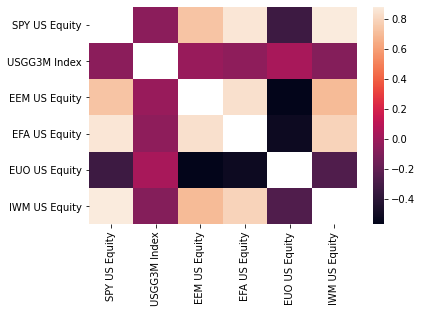

In [12]:
display_correlation(ml)

# 2.1-2.3, 2.5 Hedge-Fund Metrics

In [13]:
performanceMetrics(hf,annualization=12)

,Mean,Vol,Sharpe,Min,Max
HFRIFWI Index,0.0508,0.0615,0.8257,-0.0908,0.0586
MLEIFCTR Index,0.0388,0.0538,0.7209,-0.0532,0.0589
MLEIFCTX Index,0.0373,0.0537,0.6954,-0.0524,0.0588
HDG US Equity,0.0281,0.0564,0.4984,-0.0592,0.0583
QAI US Equity,0.0255,0.0455,0.5604,-0.0563,0.0341


In [14]:
tailMetrics(hf)

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
HFRIFWI Index,-1.1092,6.7301,-0.0253,-0.0388,-0.1155,2019-12-31,2020-03-31,2020-08-31,244 days
MLEIFCTR Index,-0.1867,2.4295,-0.0255,-0.0328,-0.0845,2019-12-31,2020-03-31,2020-11-30,335 days
MLEIFCTX Index,-0.1716,2.3756,-0.0256,-0.0327,-0.0837,2019-12-31,2020-03-31,2020-11-30,335 days
HDG US Equity,-0.1796,2.5817,-0.0285,-0.0348,-0.0882,2020-01-31,2020-03-31,2020-11-30,304 days
QAI US Equity,-0.5451,2.6696,-0.0162,-0.0263,-0.0756,2019-12-31,2020-03-31,2020-07-31,213 days


Note that the hedge-fund series have low volatilities relative to SPY or other securities we have seen. They have relatively low maximum drawdowns as well, (though not particularly low in terms of their volatility.)

Only HDG and QAI are actual returns, the others are indexes. And we note that the returns have much lower Sharpe Ratios than the series.

MIN Correlation pair is ('QAI US Equity', 'HDG US Equity')
MAX Correlation pair is ('MLEIFCTX Index', 'MLEIFCTR Index')


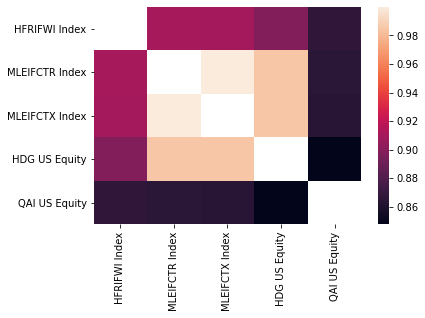

In [15]:
display_correlation(hf)

# 2.3-2.4 Relative Performance

In [16]:
get_ols_metrics(ml['SPY US Equity'],hf,annualization=12)

,alpha,SPY US Equity,r-squared,Treynor Ratio,Info Ratio
HFRIFWI Index,-0.0074,0.3943,0.7531,0.1288,-0.2420
MLEIFCTR Index,-0.0142,0.3594,0.8162,0.1080,-0.6153
MLEIFCTX Index,-0.0155,0.3580,0.8150,0.1043,-0.6713
HDG US Equity,-0.0264,0.3692,0.7857,0.0761,-1.0106
QAI US Equity,-0.0166,0.2850,0.7194,0.0894,-0.6873


### Note that 
* The alphas are all negative! SPY has been a rocket during this time.
* Hedge-funds (as measured by these broad indexes) have underperformed.
* Given that they have some SPY beta, their total return is positive (Sharpe is positive) but when we strip this factor out, the hedged performance has a negative Sharpe ratio as seen by the Info Ratio (which is the Sharpe Ratio of the hedged position.)

<AxesSubplot:xlabel='date'>

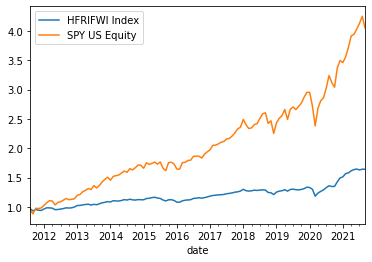

In [17]:
hfri = hf['HFRIFWI Index']
spy = ml['SPY US Equity']

cumrets = (1+pd.concat([hfri,spy],axis=1)).cumprod()
cumrets.plot()

### We see that
* HFRI is much less volatile and a much lower trend.

But maybe the scaling here is hiding how similar they are. Let's re-plot them, adjusting the scales. And we see they are *very* similar!

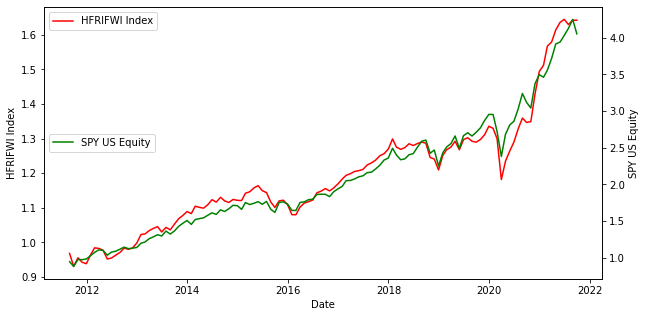

In [18]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('Date')
ax1.set_ylabel(hfri.name)
ax1.plot(hfri.index, (1+hfri).cumprod(), color='r', label=hfri.name)

ax2 = ax1.twinx()  
ax2.set_ylabel(spy.name)  
ax2.plot(spy.index, (1+spy).cumprod(), color='g', label=spy.name)

ax1.legend(loc='upper left')
ax2.legend(loc='center left')
plt.show()

# 2.6 Static Replication

In [19]:
y = hf['HFRIFWI Index']
X = sm.add_constant(ml)
static_model = sm.OLS(y,X).fit()
static_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          HFRIFWI Index   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     113.7
Date:                Mon, 11 Oct 2021   Prob (F-statistic):           5.84e-46
Time:                        21:55:01   Log-Likelihood:                 437.27
No. Observations:                 122   AIC:                            -860.5
Df Residuals:                     115   BIC:                            -840.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      1.387      0.168      -0.000       0.003
SPY US Equity     0.0720      0.042      1.725      0.087      -0.011       0.155
USGG3M Index     -0.4006      0.953     -0.420      0.675      -2.289       1.488
EEM US Equity     0.0722      0.023      3.083      0.003       0.026       0.119
EFA US Equity     0.1063      0.038      2.768      0.007       0.030       0.182
EUO US Equity     0.0224      0.018      1.245      0.216      -0.013       0.058
IWM US Equity     0.1309      0.025      5.139      0.000       0.080       0.181
==============================================================================
Omnibus:                       25.081   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.558
Skew:                          -0.600   Prob(JB):                     1.31e-20
Kurtosis:                       7.071   Cond. No.                     1.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 2.7 Rolling Replication

In [20]:
from statsmodels.regression.rolling import RollingOLS
model = RollingOLS(y,X,window=60)
rolling_betas = model.fit().params.copy()
rolling_betas

,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
date,,,,,,,
2011-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-05-31,0.0028,0.0750,-1.5348,0.1050,0.0976,0.0054,0.1474
2021-06-30,0.0027,0.0739,-1.4805,0.1050,0.0969,0.0034,0.1483
2021-07-31,0.0028,0.0685,-1.4960,0.1102,0.0947,0.0046,0.1515


In [21]:
rep_IS = (rolling_betas * X).sum(axis=1,skipna=False)
rep_OOS = (rolling_betas.shift() * X).sum(axis=1,skipna=False)

In [22]:
replication = hf[['HFRIFWI Index']].copy()
replication['Static-IS-Int'] = static_model.fittedvalues

replication['Rolling-IS-Int'] = rep_IS
replication['Rolling-OOS-Int'] = rep_OOS

replication

,HFRIFWI Index,Static-IS-Int,Rolling-IS-Int,Rolling-OOS-Int
date,,,,
2011-08-31,-0.0321,-0.0306,NaN,NaN
2011-09-30,-0.0389,-0.0397,NaN,NaN
2011-10-31,0.0269,0.0492,NaN,NaN
2011-11-30,-0.0135,-0.0022,NaN,NaN
2011-12-31,-0.0045,-0.0012,NaN,NaN
...,...,...,...,...
2021-05-31,0.0134,0.0063,0.0087,0.0082
2021-06-30,0.0054,0.0060,0.0073,0.0074
2021-07-31,-0.0091,-0.0057,-0.0075,-0.0069


In [23]:
replication.corr()

,HFRIFWI Index,Static-IS-Int,Rolling-IS-Int,Rolling-OOS-Int
HFRIFWI Index,1.0000,0.9250,0.9668,0.9445
Static-IS-Int,0.9250,1.0000,0.9921,0.9940
Rolling-IS-Int,0.9668,0.9921,1.0000,0.9956
Rolling-OOS-Int,0.9445,0.9940,0.9956,1.0000


# 2.8 Replication w/o Intercept

In [24]:
Xnoint = ml
static_model_noint = sm.OLS(y,Xnoint).fit()
betas = pd.DataFrame(static_model.params,columns=['Yes Intercept']).T
betas.loc['No Intercept'] = static_model_noint.params
betas

,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
Yes Intercept,0.0011,0.0720,-0.4006,0.0722,0.1063,0.0224,0.1309
No Intercept,NaN,0.0875,0.3345,0.0699,0.1015,0.0235,0.1290


Without an intercept, the betas are almost identical, except the beta in the 3-month T-bills. The T-bills are such low volatility, they act almost like an intercept. Thus, the regression performance is very similar.

In [25]:
model = RollingOLS(y,Xnoint,window=60,)
rolling_betas = model.fit().params.copy()
rep_IS_noint = (rolling_betas * Xnoint).sum(axis=1,skipna=False)
rep_OOS_noint = (rolling_betas.shift() * Xnoint).sum(axis=1,skipna=False)

In [26]:
replication['Static-IS-NoInt'] = static_model_noint.fittedvalues
replication['Rolling-IS-NoInt'] = rep_IS_noint
replication['Rolling-OOS-NoInt'] = rep_OOS_noint
replication

,HFRIFWI Index,Static-IS-Int,Rolling-IS-Int,Rolling-OOS-Int,Static-IS-NoInt,Rolling-IS-NoInt,Rolling-OOS-NoInt
date,,,,,,,
2011-08-31,-0.0321,-0.0306,NaN,NaN,-0.0318,NaN,NaN
2011-09-30,-0.0389,-0.0397,NaN,NaN,-0.0406,NaN,NaN
2011-10-31,0.0269,0.0492,NaN,NaN,0.0486,NaN,NaN
2011-11-30,-0.0135,-0.0022,NaN,NaN,-0.0031,NaN,NaN
2011-12-31,-0.0045,-0.0012,NaN,NaN,-0.0019,NaN,NaN
...,...,...,...,...,...,...,...
2021-05-31,0.0134,0.0063,0.0087,0.0082,0.0050,0.0058,0.0054
2021-06-30,0.0054,0.0060,0.0073,0.0074,0.0053,0.0048,0.0048
2021-07-31,-0.0091,-0.0057,-0.0075,-0.0069,-0.0063,-0.0099,-0.0100


In [27]:
performanceMetrics(replication,annualization=12)

,Mean,Vol,Sharpe,Min,Max
HFRIFWI Index,0.0508,0.0615,0.8257,-0.0908,0.0586
Static-IS-Int,0.0508,0.0569,0.8926,-0.0623,0.0535
Rolling-IS-Int,0.0612,0.0577,1.0618,-0.0664,0.0554
Rolling-OOS-Int,0.0597,0.0537,1.1117,-0.0537,0.0537
Static-IS-NoInt,0.0429,0.0574,0.7477,-0.0639,0.0528
Rolling-IS-NoInt,0.0602,0.0578,1.0417,-0.0660,0.0549
Rolling-OOS-NoInt,0.0594,0.0543,1.0934,-0.0543,0.0534


In [28]:
tailMetrics(replication)

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
HFRIFWI Index,-1.1092,6.7301,-0.0253,-0.0388,-0.1155,2019-12-31,2020-03-31,2020-08-31,244 days
Static-IS-Int,-0.5863,2.6869,-0.0273,-0.0359,-0.0974,2019-12-31,2020-03-31,2020-08-31,244 days
Rolling-IS-Int,-1.0213,5.7763,-0.0236,-0.0363,-0.0965,2019-12-31,2020-03-31,2020-08-31,244 days
Rolling-OOS-Int,-0.6601,3.9983,-0.0238,-0.0330,-0.0849,2019-12-31,2020-03-31,2020-08-31,244 days
Static-IS-NoInt,-0.5944,2.7027,-0.0283,-0.0367,-0.0997,2019-12-31,2020-03-31,2020-08-31,244 days
Rolling-IS-NoInt,-1.0060,5.5362,-0.0238,-0.0362,-0.0964,2019-12-31,2020-03-31,2020-08-31,244 days
Rolling-OOS-NoInt,-0.6808,3.8730,-0.0241,-0.0332,-0.0858,2019-12-31,2020-03-31,2020-08-31,244 days


MIN Correlation pair is ('HFRIFWI Index', 'Static-IS-NoInt')
MAX Correlation pair is ('Static-IS-Int', 'Static-IS-NoInt')


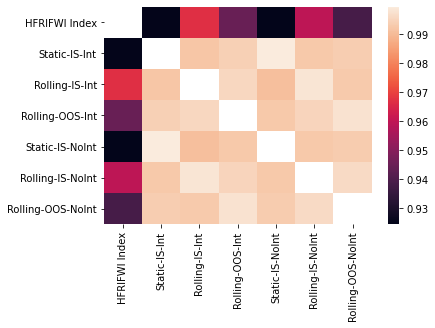

In [29]:
display_correlation(replication)

## Without the intercept
these replications are almost the same. 
* Their correlations are very high to the with-intercept versions.
* The means and other performance statistics are quite similar.

This is not always the case. The reason we get similar results with or without the intercept is due to the fact that the target has a low mean return relative to the instruments.

Just for illustration, let's look at replicating SPY with the non-SPY ML factors both with and without an intercept.

In [30]:
rep_spy = ml[['SPY US Equity']].copy()

model = sm.OLS(ml['SPY US Equity'],sm.add_constant(ml.drop(columns=['SPY US Equity'])))
rep_spy['Static-IS-Int'] = model.fit().fittedvalues
model = sm.OLS(ml['SPY US Equity'],ml.drop(columns=['SPY US Equity']))
rep_spy['Static-IS-NoInt'] = model.fit().fittedvalues
performanceMetrics(rep_spy,annualization=12)

,Mean,Vol,Sharpe,Min,Max
SPY US Equity,0.1475,0.1354,1.0900,-0.1246,0.1270
Static-IS-Int,0.1475,0.1249,1.1814,-0.1368,0.1353
Static-IS-NoInt,0.1083,0.1274,0.8497,-0.1457,0.1339


We see that replicating SPY without an intercept loses a significant amount of the mean return and Sharpe--even though one of the replicating instruments (IWM) is highly correlated to SPY with a high mean!

# Extensions - Constrained Regression

## Non-Negative Betas

In [31]:
reg_nnls = LinearRegression(positive=True,fit_intercept=True)
mod = reg_nnls.fit(Xnoint, y)
betas.loc['Yes intercept: NNLS',Xnoint.columns] =  + mod.coef_
betas.loc['Yes intercept: NNLS','const'] = mod.intercept_
betas

,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
Yes Intercept,0.0011,0.0720,-0.4006,0.0722,0.1063,0.0224,0.1309
No Intercept,NaN,0.0875,0.3345,0.0699,0.1015,0.0235,0.1290
Yes intercept: NNLS,0.0010,0.0717,0.0000,0.0715,0.1066,0.0221,0.1318


## Similar to unconstrained

The unconstrained estimate shorted treasury bills, which are extremely low volatility.
The constrained estimate simply zeros out the t-bill exposure, ye tthis does not impact the total result much.

In [32]:
replication['Static-IS-Int-NNLS'] = mod.predict(Xnoint)
corr_nnls = replication.corr().loc['Static-IS-Int-NNLS','Static-IS-Int']
print(f'Correlation between unconstrained and constrained is {corr_nnls:0.4f}')

Correlation between unconstrained and constrained is 0.9999


## Constrained by coefficient-specific inequalities

We will likely discuss this later.

# Extensions - More Style Analysis

In [33]:
data = pd.read_excel(filepath_data,sheet_name='other_data')
data.set_index('date',inplace=True)
data.drop(columns=['SPXU US Equity','UPRO US Equity'],inplace=True)

info.loc[data.columns]

,Descriptions
TRVCI Index,Refinitiv VC Index
HEFA US Equity,ISHA CURR HEDGED MSCI EAFE
TAIL US Equity,CAMBRIA TAIL RISK ETF


In [34]:
performanceMetrics(data,annualization=12)

,Mean,Vol,Sharpe,Min,Max
TRVCI Index,0.2857,0.2369,1.2057,-0.1488,0.1864
HEFA US Equity,0.0847,0.1244,0.6810,-0.1316,0.1234
TAIL US Equity,-0.0452,0.1259,-0.3594,-0.0891,0.1141


In [35]:
tailMetrics(data)

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
TRVCI Index,-0.1362,-0.3174,-0.0933,-0.1108,-0.2383,2018-09-30,2018-12-31,2019-04-30,212 days
HEFA US Equity,-0.6661,2.7149,-0.0566,-0.0819,-0.2066,2019-12-31,2020-03-31,2020-12-31,366 days
TAIL US Equity,1.3693,3.2173,-0.0430,-0.0610,-0.2158,2020-03-31,2021-05-31,NaT,NaT


MIN Correlation pair is ('HEFA US Equity', 'TAIL US Equity')
MAX Correlation pair is ('SPY US Equity', 'HEFA US Equity')


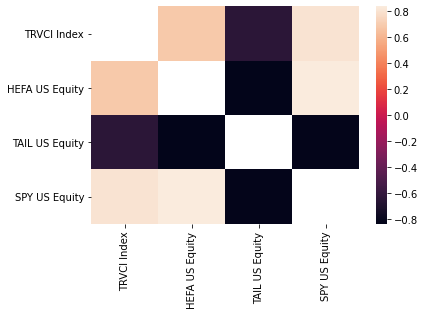

In [36]:
display_correlation(data.join(ml['SPY US Equity']))

In [37]:
get_ols_metrics(ml,data,annualization=12)

,alpha,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,r-squared,Info Ratio
TRVCI Index,0.0478,1.7351,2.9773,-0.0882,0.1172,-0.0202,-0.2905,0.6622,0.3474
HEFA US Equity,0.0125,0.0340,-0.4832,-0.0848,0.9779,0.3099,0.0164,0.9722,0.6028
TAIL US Equity,0.0636,-0.2800,-1.2214,-0.1248,-0.1841,-0.2834,-0.1476,0.7738,1.0627


# Extensions - Levered ETFs

See other notebook